# Oferta e Demanda

In [2]:
import pandas as pd
import numpy as np
import json
import importlib, sys, os, requests
from datetime import date, datetime

from pathlib import Path
sys.path.append(str(Path(os.path.abspath('')).parents[0]))

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import yfinance as yf
import investpy

import support_library as sl

_ = [importlib.reload(sys.modules[m]) for m in list(sys.modules) if 'support_library' in m]

In [5]:
DATE_FORMAT = '%Y-%m-%d'
MIN_DATE    = "2010-01-01"
TODAY       = date.today()
TODAY_STR   = date.today().strftime(DATE_FORMAT)
REF_MES     = 12 

DATASET     = r'../dataset/'

TODAY

datetime.date(2022, 3, 30)

# Preco Soja

In [3]:
df_soja = sl.soybean.get_all_prices()
print(df_soja.shape)
df_soja.head()

(3043, 13)


,sb_grain_future_price,sb_grain_future_volume,sb_grain_spot_price,sb_grain_spot_volume,sb_oil_future_price,sb_oil_future_volume,sb_oil_spot_price,sb_oil_spot_volume,sb_meal_future_price,sb_meal_future_volume,sb_meal_spot_price,sb_meal_spot_volume,date
Date,,,,,,,,,,,,,
2010-01-04,385.63,25947,388.75,87661.0,901.69,24855.0,910.29,51055.0,348.33,3802.0,339.84,22970.0,2010-01-04
2010-01-05,386.64,21073,389.85,63725.0,897.50,10840.0,906.10,26802.0,352.08,3162.0,343.26,16625.0,2010-01-05
2010-01-06,385.99,17567,389.12,63223.0,896.62,9257.0,905.44,35365.0,350.42,2183.0,341.94,16785.0,2010-01-06
2010-01-07,373.96,11750,376.99,88966.0,881.63,4976.0,889.79,147.0,338.41,3298.0,328.71,285.0,2010-01-07
2010-01-08,372.21,11750,375.52,73190.0,871.49,4976.0,879.87,35634.0,338.19,3298.0,328.82,24729.0,2010-01-08


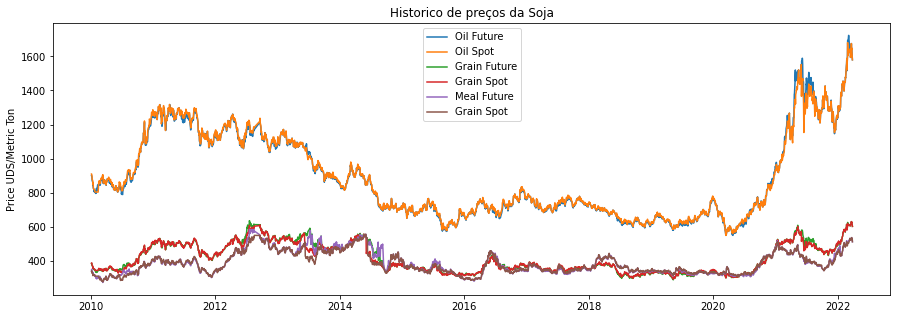

In [4]:
plt.figure(figsize=(15,5))

plt.plot(df_soja.index, df_soja['sb_oil_future_price'], label='Oil Future', );
plt.plot(df_soja.index, df_soja['sb_oil_spot_price'], label='Oil Spot');
plt.plot(df_soja.index, df_soja['sb_grain_future_price'], label='Grain Future');
plt.plot(df_soja.index, df_soja['sb_grain_spot_price'], label='Grain Spot');
plt.plot(df_soja.index, df_soja['sb_meal_future_price'], label='Meal Future');
plt.plot(df_soja.index, df_soja['sb_meal_spot_price'], label='Grain Spot');
plt.title("Historico de preços da Soja")
plt.ylabel('Price UDS/Metric Ton')
plt.legend(loc='best');

In [6]:
df_soja.to_csv(f'{DATASET}\__preco_soja.csv')
sl.save_excel(df_soja, f'{DATASET}\__preco_soja.xlsx')

# Preço Girassol

In [13]:
df_vol = df_soja[['sb_oil_spot_price', 'sb_oil_spot_volume']]
df_vol
df_vol

,sb_oil_spot_price,sb_oil_spot_volume
Date,,
2010-01-04,910.29,51055.0
2010-01-05,906.10,26802.0
2010-01-06,905.44,35365.0
2010-01-07,889.79,147.0
2010-01-08,879.87,35634.0
...,...,...
2022-03-23,1674.85,31251.0
2022-03-24,1637.81,35571.0
2022-03-25,1647.96,31999.0
